# Sumarização de Múltiplos Documentos Científicos Usando o Dataset SurveySum

## 1. Objetivo do Projeto
O objetivo do projeto será desenvolver um sistema que realiza sumarização de múltiplos documentos científicos nas áreas de Inteligência Artificial (IA), Processamento de Linguagem Natural (PLN) e Aprendizado de Máquina (ML), utilizando o dataset SurveySum. O foco será em criar uma solução que possa gerar uma seção de revisão de literatura com base em um conjunto de artigos científicos relacionados a um tema específico.

## 2. Escopo do Projeto
Este projeto está dividido em etapas práticas e definidas:

### Exploração do Dataset SurveySum:

* Compreender a estrutura do SurveySum e selecionar uma pequena parte do dataset (por exemplo, algumas seções de surveys) para treinar e testar o modelo.

### Modelo de Sumarização:

* Utilizar um modelo de linguagem pré-treinado Pegasus para a tarefa de sumarização abstrativa. Esses modelos são eficazes para resumir textos longos e podem ser ajustados para essa tarefa.
* Implementar um pipeline simples de retrieval + summarization:
** Recuperação: Coletar e segmentar os artigos científicos relacionados ao tema
** Sumarização: Alimentar esses textos segmentados no modelo de linguagem para gerar o resumo (seção do survey).

###  Avaliação da Qualidade:

* Avaliar a qualidade das sumarizações geradas com base em métricas automáticas simples, como ROUGE (para medir a sobreposição entre os textos de referência e os textos gerados) ou uma avaliação manual, comparando com as seções do survey original.
* Para simplificar, será testado o modelo em apenas algumas seções do survey para verificar se o modelo consegue gerar resumos coesos e relevantes.

### Relatório Final:

* Documentar o pipeline implementado e os resultados obtidos, discutindo as limitações e sugerindo melhorias. O foco será na eficácia do modelo em gerar resumos adequados e coesos com base em múltiplos documentos científicos.
* O relatório pode incluir uma análise dos resultados e a proposta de como o projeto poderia ser expandido para tarefas mais complexas no futuro.

## 3. Ferramentas e Tecnologias
* Dataset: SurveySum (disponível no Hugging Face Datasets).
* Modelo de Sumarização: Pegasus.
* Ambiente de Desenvolvimento: Google Colab (para experimentos com modelos de linguagem e acesso ao dataset).
* Avaliação: Métricas como ROUGE para medir a qualidade dos resumos gerados.

# Configuração Inicial e Importação de Pacotes.

In [ ]:
# Instalar bibliotecas específicas (executar no Colab)
!pip install transformers datasets sentence-transformers rouge_score

# Importação das bibliotecas necessárias
from transformers import BartForConditionalGeneration, BartTokenizer
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, util
import torch
import numpy as np


In [ ]:
!pip install datasets transformers


# Dataset

### A. Dataset SurveySum

#### 1. Estrutura do Dataset:

O comando print(dataset) exibe a estrutura do dataset carregado. Nesse caso, a saída mostra que o dataset SurveySum contém um conjunto de dados chamado train (treinamento) com 79 entradas.
#### 2. Campos do Dataset:

* Cada entrada do dataset tem os seguintes campos:
** survey_id: Identificador único para cada survey (ou seção de survey).
** survey_title: Título da survey, que indica o tópico geral da seção.
** section_title: Título da seção específica dentro do survey.
** generated_section_text: Texto gerado automaticamente para a seção, provavelmente criado por modelos de linguagem ou humanos.
** citations: Referências dos artigos utilizados para compor a seção de survey.
** section_text_in_survey: Texto de referência para a seção, que representa o resumo ideal dos artigos citados.

#### 3. Significado dos Dados:

Esses campos são organizados para ajudar em tarefas de sumarização multidocumento, onde o objetivo é gerar uma seção de survey coesa a partir de múltiplos artigos. O campo section_text_in_survey pode ser usado como resumo de referência para comparar a qualidade de resumos gerados automaticamente.

In [ ]:
# Importa a função 'load_dataset' da biblioteca 'datasets' para carregar datasets do Hugging Face
from datasets import load_dataset

# Carrega o dataset "SurveySum" da plataforma Hugging Face.
# Este dataset foi criado especificamente para sumarização multidocumento, onde o objetivo é gerar uma seção de survey
# (resumo de múltiplos artigos) a partir de artigos científicos relacionados.
dataset = load_dataset("unicamp-dl/SurveySum")

# Exibe a estrutura geral do dataset carregado, mostrando seus diferentes conjuntos (por exemplo, train, test).
# Esse print ajuda a visualizar as características principais do dataset, como os campos e a quantidade de amostras.
print("Estrutura do Dataset SurveySum:")
print(dataset)


Estrutura do Dataset SurveySum:
DatasetDict({
    train: Dataset({
        features: ['survey_id', 'survey_title', 'section_title', 'generated_section_text', 'citations', 'section_text_in_survey'],
        num_rows: 79
    })
})


### B. Conteúdo da Estrutura de Saída do Dataset

Este código ajuda a verificar o conteúdo e a estrutura de cada campo de uma entrada do SurveySum. A exibição organizada facilita a leitura e compreensão das informações, especialmente no caso de textos longos. Isso é fundamental para um entendimento inicial do dataset, permitindo identificar rapidamente as referências e a estrutura dos dados que serão utilizados no projeto.
Ele é útil para verificar a estrutura e o conteúdo de um exemplo típico do dataset antes de implementar outros passos do pipeline. Abaixo está uma explicação detalhada de cada parte do código e o que esperar na saída.

#### 1. Exibição dos Campos Principais da Entrada

* A primeira parte do código armazena a primeira entrada do dataset (dataset['train'][2]) e exibe os campos principais com uma formatação clara e organizada:
** Survey ID: Exibe o identificador único da survey.
** Survey Title: Exibe o título do survey.
** Section Title: Exibe o título da seção específica do survey.
* Esses campos permitem identificar o tema e a seção do survey que está sendo exibido, fornecendo contexto inicial.

#### 2. Exibição do Texto Gerado (Generated Section Text)

* O campo generated_section_text contém uma estrutura que armazena os chunks de texto associados a referências bibliográficas, cada um identificado por um código (BIBREF).
* O código verifica se existem chunks na estrutura autosurvey_t5_3b_10_chunks. Caso existam, exibe cada chunk com uma referência (BIBREF) e um trecho do texto associado (limitado a 100 caracteres para simplificar a visualização).

Exemplo de Saída:

**Referência: BIBREF14 | Texto: ...representative example, the Chain-of-Thought prompts largely improve the performance...**

Essa parte ajuda a entender como os chunks referenciam artigos específicos e como são utilizados para compor a seção do survey.

#### 3. Exibição das Citações (Citations)

* Este código exibe o conjunto completo de 266 citações (BIBREF), que representam todas as referências bibliográficas utilizadas no dataset SurveySum.
Independentemente da entrada selecionada, o número de citações exibido será sempre o mesmo, pois o conjunto de citações reflete todas as referências que podem ser associadas aos chunks ao longo de todas as seções do survey.

Citations:
  1. BIBREF0
  2. BIBREF1
  ...
  Total de citações: 266

* Embora cada entrada utilize apenas uma parte das 266 citações em seus chunks, o código exibe todas as possíveis citações do dataset para fornecer uma visão geral das referências disponíveis.

#### 4. Exibição do Texto de Referência da Seção (Section Text in Survey)

* O texto de referência representa o resumo "gold standard" para a seção, criado para ser o modelo ideal de sumarização.

* A caixa de texto permite visualizar de maneira clara o texto de referência completo da seção, que é o objetivo final de uma sumarização precisa.

Finalidade e Benefícios da Estrutura de Saída
Este código ajuda a verificar o conteúdo e a estrutura de cada campo de uma entrada do SurveySum. A exibição organizada facilita a leitura e compreensão das informações, especialmente no caso de textos longos. Isso é fundamental para um entendimento inicial do dataset, permitindo identificar rapidamente as referências e a estrutura dos dados que serão utilizados no projeto.

In [ ]:
# Esse código tem a finalidade de exibir as primeiras linhas do dataset SurveySum,
# apresentando os campos principais da primeira entrada para uma inspeção inicial.

# Exibir a primeira entrada do conjunto de treinamento do SurveySum de forma organizada
print("=== Primeira Entrada do Dataset de Treinamento (SurveySum) ===\n")

# Armazena a primeira entrada do dataset de treinamento para visualização organizada
primeira_entrada = dataset['train'][2]

# Exibe cada campo com formatação organizada
print("Survey ID:", primeira_entrada['survey_id'])
print("\nSurvey Title:")
print(f"  {primeira_entrada['survey_title']}")
print("\nSection Title:")
print(f"  {primeira_entrada['section_title']}")

# Exibe o texto gerado, se disponível e estruturado como dicionário, com extração dos principais chunks de texto
print("\nGenerated Section Text:")
generated_text = primeira_entrada.get('generated_section_text')
if isinstance(generated_text, dict) and 'autosurvey_t5_3b_10_chunks' in generated_text:
    autosurvey = generated_text['autosurvey_t5_3b_10_chunks']
    if 'references_sent_to_gpt' in autosurvey:
        print("  Referências e Chunks de Texto:")
        for i, ref_chunk in enumerate(autosurvey['references_sent_to_gpt'], 1):
            bibref = ref_chunk.get('bibref', 'Sem referência')
            chunk_text = ref_chunk.get('chunk', 'Texto não disponível')
           # print(f"    {i}. Referência: {bibref} | Texto: {chunk_text}")  # Exibe o texto completo

            print(f"    {i}. Referência: {bibref} | Texto: {chunk_text[:100]}...")  # Limita a exibição a 100 caracteres
    else:
        print("  (Referências e chunks de texto não disponíveis)")
else:
    print("  (Texto gerado não disponível ou não estruturado conforme esperado)")

# Exibe as citações de forma numerada
print("\nCitations:")

# Obtém as chaves das primeiras 10 citações do dicionário de citações
citation_keys = list(primeira_entrada['citations'].keys())[:10]
total_citations = len(primeira_entrada['citations'])  # Total de citações

# Exibe até as primeiras 10 citações
for i, citation_key in enumerate(citation_keys, 1):
    print(f"  {i}. {citation_key}")  # Exibe cada chave de citação numerada

# Indica que existem mais citações, se o total for maior que 10
if total_citations > 10:
    print("  ...")  # Indica que há mais citações
    print(f"  Total de citações: {total_citations}")  # Exibe o número total de citações

# Exibe o texto de referência da seção em uma "caixa de texto" para facilitar a leitura
print("\nSection Text in Survey (Referência):")

# Verifica se o texto de referência está disponível e é uma string
if isinstance(primeira_entrada.get('section_text_in_survey'), str) and primeira_entrada['section_text_in_survey']:
    # Limita a exibição a 500 caracteres e quebra em várias linhas
    text = primeira_entrada['section_text_in_survey'][::]
    box_width = 160  # Largura da caixa de texto

    # Divide o texto em linhas de exatamente 'box_width' caracteres
    lines = [text[i:i + box_width].ljust(box_width) for i in range(0, len(text), box_width)]

    # Imprime o texto dentro de uma caixa com bordas alinhadas
    print("┌" + "─" * (box_width+2) + "┐")
    for line in lines:
        print("│ " + line + " │")
    print("└" + "─" * (box_width +2) + "┘")
else:
    print("  (Texto de referência não disponível)")



=== Primeira Entrada do Dataset de Treinamento (SurveySum) ===

Survey ID: 2309.15402v1

Survey Title:
  A Survey of Chain of Thought Reasoning: Advances, Frontiers and Future

Section Title:
  Methods::XoT Structural Variants::Tree Structure

Generated Section Text:
  Referências e Chunks de Texto:
    1. Referência: BIBREF14 | Texto: ...representative example, the Chain-of-Thought prompts largely improve the performance on tasks tha...
    2. Referência: BIBREF16 | Texto: ...that require exploration, strategic lookahead, or where initial decisions play a pivotal role. To...
    3. Referência: BIBREF80 | Texto: ...aug 2022. [14] Xuezhi Wang, Jason Wei, Dale Schuurmans, Quoc Le, Ed Chi, Sharan Narang, Aakanksha...

Citations:
  1. BIBREF0
  2. BIBREF1
  3. BIBREF10
  4. BIBREF100
  5. BIBREF101
  6. BIBREF102
  7. BIBREF103
  8. BIBREF104
  9. BIBREF105
  10. BIBREF106
  ...
  Total de citações: 266

Section Text in Survey (Referência):
┌────────────────────────────────────────────────

### C. Exibição Completa de Citações e Chunks Associados no Dataset SurveySum

Este código tem como objetivo exibir todas as citações presentes no dataset SurveySum, juntamente com os chunks de texto associados a cada uma delas, se disponíveis. Ele é importante para:

#### 1. Verificação de Referências e Conteúdo Associado:

Ao mostrar cada citação e seus chunks, o código permite uma análise detalhada da relação entre as referências bibliográficas (BIBREF) e os textos extraídos. Isso ajuda a entender a extensão e profundidade do uso de cada citação em diferentes partes do survey.
#### 2. Preparação para Sumarização:

Esse processo é essencial para a etapa de sumarização multidocumento, pois permite identificar os trechos de texto relevantes associados a cada citação. Esse é um passo importante para estruturar a entrada que será processada pelo modelo de sumarização.
#### 3. Organização e Acesso aos Dados:

Armazenar os chunks em um dicionário facilita o acesso e manipulação dos dados, permitindo que outras operações (como a criação de resumos) sejam realizadas de forma mais eficiente.


In [ ]:
# Esse código tem a finalidade de exibir todas as citações no dataset SurveySum,
# junto com os chunks de texto correspondentes, caso existam.

# Exibe todas as citações e os chunks correspondentes
print("=== Exibindo Todas as Citações e Seus Chunks Correspondentes ===\n")

# Cria um dicionário para armazenar todas as citações e seus chunks associados
citations_dict = {}

# Percorre cada entrada no dataset para coletar os chunks e suas citações
for entrada in dataset['train']:
    # Verifica se existem chunks de texto gerados
    generated_text = entrada.get('generated_section_text')

    if generated_text and 'autosurvey_t5_3b_10_chunks' in generated_text:
        autosurvey = generated_text['autosurvey_t5_3b_10_chunks']

        # Verifica se há referências e chunks para exibir
        if 'references_sent_to_gpt' in autosurvey:
            for ref_chunk in autosurvey['references_sent_to_gpt']:
                bibref = ref_chunk.get('bibref', 'Sem referência')  # Identificador da citação
                chunk_text = ref_chunk.get('chunk', 'Texto não disponível')  # Texto do chunk

                # Adiciona o chunk ao dicionário de citações
                if bibref not in citations_dict:
                    citations_dict[bibref] = []
                citations_dict[bibref].append(chunk_text)

# Exibe todas as citações e seus chunks
for bibref, chunks in citations_dict.items():
    print(f"\nReferência: {bibref}")
    for i, chunk_text in enumerate(chunks, 1):
        print(f"  Chunk {i}: {chunk_text[:150]}...")  # Limita a exibição do chunk a 150 caracteres

print("\n=== Fim da Exibição das Citações e Chunks ===")


=== Exibindo Todas as Citações e Seus Chunks Correspondentes ===


Referência: BIBREF358
  Chunk 1: ...many research areas, including 1) Computer-based musical analysis (Volk et al., 2011; Meredith, 2016) such as using computers to analyse the struct...

Referência: BIBREF179
  Chunk 1: ...collected for training and evaluating melody harmonization. In addition to conducting a subjective evaluation, we employed in total six objective m...
  Chunk 2: ...Island, Korea, pages 1–40. ACL. Xipeng Qiu, Tianxiang Sun, Yige Xu, Yunfan Shao, Ning Dai, and Xuanjing Huang. 2020. Pre-trained models for natural...

Referência: BIBREF306
  Chunk 1: ...a given sentiment. This paper presents a generative Deep Learning model that can be directed to compose music with a given sentiment. Besides music...

Referência: BIBREF355
  Chunk 1: ...Association 1(3). [Bertin-Mahieux et al. 2011] Bertin-Mahieux, T.; Ellis, D. P.; Whitman, B.; and Lamere, P. 2011. The million song dataset. 12th I...

Referência: BIBR

### D. Contagem de Chunks por Citação e Totalização no Dataset SurveySum

Este código calcula quantos chunks de texto estão associados a cada citação (identificadas por BIBREF) no dataset SurveySum e, ao final, exibe uma totalização do número de citações e chunks presentes. É útil para entender a distribuição e quantidade de informações (chunks) que cada citação traz para o dataset, fornecendo uma visão quantitativa da relação entre as fontes (citações) e os trechos de texto associados (chunks).

In [ ]:
# Esse código tem a finalidade de contar quantos chunks estão associados a cada citação (BIBREF)
# e exibir uma totalização de chunks e citações ao final.

# Dicionário para armazenar a contagem de chunks para cada citação
chunks_por_citacao = {}

# Variável para contar o total de chunks
total_chunks = 0

# Percorre cada entrada no dataset para coletar os chunks e suas citações
for entrada in dataset['train']:
    # Verifica se existem chunks de texto gerados
    generated_text = entrada.get('generated_section_text')

    if generated_text and 'autosurvey_t5_3b_10_chunks' in generated_text:
        autosurvey = generated_text['autosurvey_t5_3b_10_chunks']

        # Verifica se há referências e chunks para contabilizar
        if 'references_sent_to_gpt' in autosurvey:
            for ref_chunk in autosurvey['references_sent_to_gpt']:
                bibref = ref_chunk.get('bibref', 'Sem referência')  # Identificador da citação

                # Incrementa a contagem de chunks para a citação específica
                if bibref not in chunks_por_citacao:
                    chunks_por_citacao[bibref] = 0
                chunks_por_citacao[bibref] += 1

                # Incrementa o contador total de chunks
                total_chunks += 1

# Exibe a quantidade de chunks para cada citação
print("=== Contagem de Chunks por Citação ===")
for bibref, count in chunks_por_citacao.items():
    print(f"Citação {bibref}: {count} chunks")

# Exibe a totalização de chunks e citações
total_citacoes = len(chunks_por_citacao)
print("\n=== Totalização ===")
print(f"Total de citações com chunks: {total_citacoes}")
print(f"Total de chunks: {total_chunks}")


=== Contagem de Chunks por Citação ===
Citação BIBREF358: 1 chunks
Citação BIBREF179: 2 chunks
Citação BIBREF306: 1 chunks
Citação BIBREF355: 1 chunks
Citação BIBREF199: 3 chunks
Citação BIBREF354: 1 chunks
Citação BIBREF357: 1 chunks
Citação BIBREF356: 1 chunks
Citação BIBREF312: 1 chunks
Citação BIBREF316: 1 chunks
Citação BIBREF70: 4 chunks
Citação BIBREF104: 6 chunks
Citação BIBREF71: 3 chunks
Citação BIBREF16: 4 chunks
Citação BIBREF166: 3 chunks
Citação BIBREF81: 3 chunks
Citação BIBREF82: 5 chunks
Citação BIBREF80: 5 chunks
Citação BIBREF127: 1 chunks
Citação BIBREF14: 2 chunks
Citação BIBREF89: 2 chunks
Citação BIBREF90: 4 chunks
Citação BIBREF91: 2 chunks
Citação BIBREF92: 2 chunks
Citação BIBREF88: 2 chunks
Citação BIBREF87: 1 chunks
Citação BIBREF86: 6 chunks
Citação BIBREF21: 2 chunks
Citação BIBREF20: 1 chunks
Citação BIBREF13: 4 chunks
Citação BIBREF85: 4 chunks
Citação BIBREF84: 5 chunks
Citação BIBREF83: 4 chunks
Citação BIBREF79: 4 chunks
Citação BIBREF78: 2 chunks
Cit

### E. Exibição Enumerada dos Títulos de Surveys e Seções no Dataset SurveySum

Este código exibe os títulos dos surveys e suas respectivas seções no dataset SurveySum, enumerando cada entrada para facilitar a visualização e compreensão da estrutura do dataset. É útil para uma exploração inicial do dataset, oferecendo uma visão geral de todos os surveys e suas seções, permitindo identificar temas e estrutura de conteúdo presentes no SurveySum.

In [ ]:
# Exibir os títulos das seções (section_title) e os títulos dos surveys (survey_title) enumerados
for i in range(79):
    print(f"Survey {i+1}:")
    print(f"Survey Title: {dataset['train'][i]['survey_title']}")
    print(f"Section Title: {dataset['train'][i]['section_title']}")
    print()  # Linha em branco para separar cada survey


Survey 1:
Survey Title: A Comprehensive Survey on Deep Music Generation: Multi-level Representations, Algorithms, Evaluations, and Future Directions
Section Title: Datasets::MIDI

Survey 2:
Survey Title: A Survey of Chain of Thought Reasoning: Advances, Frontiers and Future
Section Title: Discussion::Comparison between Verification/Refinement and Planning

Survey 3:
Survey Title: A Survey of Chain of Thought Reasoning: Advances, Frontiers and Future
Section Title: Methods::XoT Structural Variants::Tree Structure

Survey 4:
Survey Title: A Survey of Data Augmentation Approaches for NLP
Section Title: Applications::Adversarial Examples (AVEs)

Survey 5:
Survey Title: A Survey of Data Augmentation Approaches for NLP
Section Title: Applications::Few-Shot Learning

Survey 6:
Survey Title: A Survey of Data Augmentation Approaches for NLP
Section Title: Applications::Fixing Class Imbalance

Survey 7:
Survey Title: A Survey of Data Augmentation Approaches for NLP
Section Title: Applications::M

In [ ]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from sentence_transformers import SentenceTransformer, util
import torch

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch
from sentence_transformers.util import pytorch_cos_sim

# Carregar o modelo e tokenizer do SciBERT
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
scibert_model = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")

# Função para gerar embeddings com o SciBERT
def gerar_embedding_scibert(texto):
    """
    Gera o embedding para um texto usando SciBERT.

    Parâmetros:
    - texto: string com o texto a ser embeddado.

    Retorna:
    - tensor de embedding do SciBERT para o texto.
    """
    tokens = tokenizer(texto, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = scibert_model(**tokens)
    # Pegando a média das representações da última camada para obter o embedding final
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings

# Função para recuperar os chunks mais relevantes com base na similaridade
def recuperar_chunks_relevantes_scibert(entrada, num_chunks=5):
    """
    Recupera os 'num_chunks' mais relevantes de uma entrada específica do dataset com base na similaridade de embeddings com SciBERT.

    Parâmetros:
    - entrada: dicionário com os dados de uma seção do dataset.
    - num_chunks: número de chunks mais relevantes a serem selecionados.

    Retorna:
    - lista de tuplas (similaridade, chunk) para os chunks mais relevantes.
    """
    # Obter o título da seção e gerar embedding
    titulo_secao = entrada['section_title']
    titulo_embedding = gerar_embedding_scibert(titulo_secao)

    # Extrair os chunks de 'references_sent_to_gpt' e gerar embeddings
    chunks = entrada['generated_section_text']['autosurvey_t5_3b_10_chunks']['references_sent_to_gpt']
    chunks_textos = [chunk['chunk'] for chunk in chunks]
    chunks_embeddings = torch.cat([gerar_embedding_scibert(chunk) for chunk in chunks_textos])

    # Calcular a similaridade entre o título e cada chunk
    similaridades = pytorch_cos_sim(titulo_embedding, chunks_embeddings).squeeze(0)

    # Ordenar os chunks pela similaridade e selecionar os mais relevantes
    indices_relevantes = torch.topk(similaridades, k=min(num_chunks, len(chunks_textos))).indices
    chunks_relevantes = [(similaridades[i].item(), chunks_textos[i]) for i in indices_relevantes]

    return chunks_relevantes

# Testando a função com a primeira entrada do dataset
entrada_exemplo = dataset['train'][10]  # Seleciona a primeira entrada do dataset para teste
chunks_relevantes_exemplo = recuperar_chunks_relevantes_scibert(entrada_exemplo)  # Recupera os chunks relevantes
print("Chunks Relevantes Selecionados:\n")  # Exibe os chunks relevantes

# Exibe os chunks selecionados de forma enumerada
for i, chunk in enumerate(chunks_relevantes_exemplo, 1):
    print(f"{i}. Similaridade: {chunk[0]:.4f} | Chunk: {chunk[1][:100]}...")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Chunks Relevantes Selecionados:

1. Similaridade: 0.6880 | Chunk: ...Data Augmentation. Compared to vision, a few efforts have been done on augmenting text for classi...
2. Similaridade: 0.6456 | Chunk: ...of labeled multimodal data, we propose a Multimodal Data Augmentation (MDA) framework for boostin...
3. Similaridade: 0.6395 | Chunk: ...Data augmentation has a long history in image processing (Shorten and Khoshgoftaar, 2019). In lan...
4. Similaridade: 0.6388 | Chunk: ...as it only uses text data, but provides only modest improvements in performance. And while multil...
5. Similaridade: 0.6208 | Chunk: ...generated by our method improves IQA performance as compared to the baseline trained with the ori...


In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch
from sentence_transformers.util import pytorch_cos_sim

# Carregar o modelo e tokenizer do SciBERT
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
scibert_model = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")

# Função para gerar embeddings com o SciBERT
def gerar_embedding_scibert(texto):
    """
    Gera o embedding para um texto usando SciBERT.

    Parâmetros:
    - texto: string com o texto a ser embeddado.

    Retorna:
    - tensor de embedding do SciBERT para o texto.
    """
    tokens = tokenizer(texto, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = scibert_model(**tokens)
    # Pegando a média das representações da última camada para obter o embedding final
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings

# Função para recuperar os chunks mais relevantes com base na similaridade
def recuperar_chunks_relevantes_scibert(entrada, num_chunks=5):
    """
    Recupera os 'num_chunks' mais relevantes de uma entrada específica do dataset com base na similaridade de embeddings com SciBERT.

    Parâmetros:
    - entrada: dicionário com os dados de uma seção do dataset.
    - num_chunks: número de chunks mais relevantes a serem selecionados.

    Retorna:
    - lista de tuplas (similaridade, chunk) para os chunks mais relevantes.
    """
    # Obter o título da seção e gerar embedding
    titulo_secao = entrada['section_title']
    titulo_embedding = gerar_embedding_scibert(titulo_secao)

    # Extrair os chunks de 'references_sent_to_gpt' e gerar embeddings
    chunks = entrada['generated_section_text']['autosurvey_t5_3b_10_chunks']['references_sent_to_gpt']
    chunks_textos = [chunk['chunk'] for chunk in chunks]
    chunks_embeddings = torch.cat([gerar_embedding_scibert(chunk) for chunk in chunks_textos])

    # Calcular a similaridade entre o título e cada chunk
    similaridades = pytorch_cos_sim(titulo_embedding, chunks_embeddings).squeeze(0)

    # Ordenar os chunks pela similaridade e selecionar os mais relevantes
    indices_relevantes = torch.topk(similaridades, k=min(num_chunks, len(chunks_textos))).indices
    chunks_relevantes = [(similaridades[i].item(), chunks_textos[i]) for i in indices_relevantes]

    return chunks_relevantes

# Função para calcular a média das similaridades dos chunks relevantes
def calcular_media_similaridade(chunks_relevantes):
    """
    Calcula a média das similaridades dos chunks relevantes.

    Parâmetros:
    - chunks_relevantes: lista de tuplas (similaridade, chunk)

    Retorna:
    - média das similaridades
    """
    similaridades = [sim for sim, _ in chunks_relevantes]
    media_similaridade = sum(similaridades) / len(similaridades) if similaridades else 0
    return media_similaridade

# Testando a função com a primeira entrada do dataset
entrada_exemplo = dataset['train'][0]  # Seleciona uma entrada do dataset para teste
chunks_relevantes_exemplo = recuperar_chunks_relevantes_scibert(entrada_exemplo)  # Recupera os chunks relevantes
print("Chunks Relevantes Selecionados:\n")  # Exibe os chunks relevantes

# Exibe os chunks selecionados de forma enumerada
for i, chunk in enumerate(chunks_relevantes_exemplo, 1):
    print(f"{i}. Similaridade: {chunk[0]:.4f} | Chunk: {chunk[1][:100]}...")

# Calcula e exibe a média das similaridades
media_similaridade = calcular_media_similaridade(chunks_relevantes_exemplo)
print(f"\nMédia de Similaridade dos Chunks Relevantes: {media_similaridade:.4f}")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Chunks Relevantes Selecionados:

1. Similaridade: 0.5814 | Chunk: ...proposed ficta hurt the harmony. One of the main advantages of the music21 framework is making su...
2. Similaridade: 0.5663 | Chunk: ...note to be off. Using regularization methods such as weight decay has not proven efficient. We be...
3. Similaridade: 0.5546 | Chunk: ...on the result, fine-tunes them in note-level. A listening test with professional pianists shows t...
4. Similaridade: 0.5444 | Chunk: ...many research areas, including 1) Computer-based musical analysis (Volk et al., 2011; Meredith, 2...
5. Similaridade: 0.5420 | Chunk: ...FUTURE OF THE DATASET Time will tell how useful the MSD proves to be, but here are our thoughts r...

Média de Similaridade dos Chunks Relevantes: 0.5577


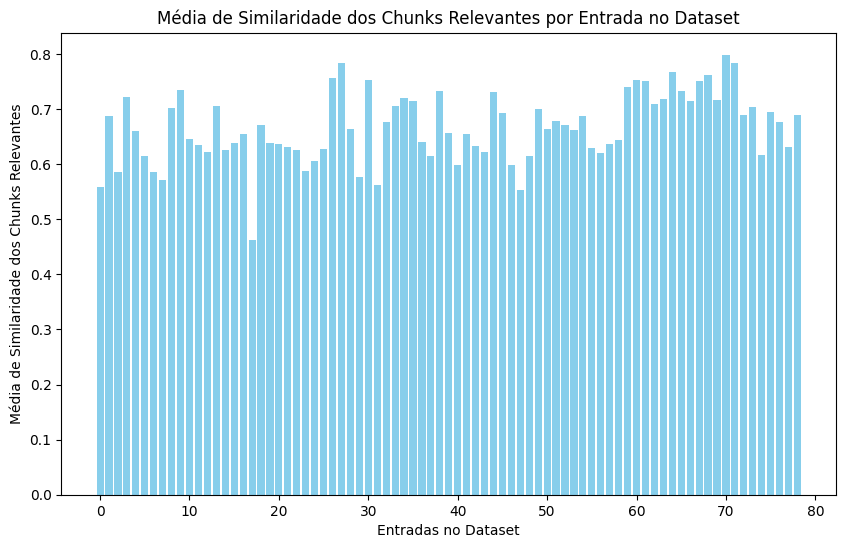

In [ ]:
import matplotlib.pyplot as plt

# Função para calcular a média de similaridade dos chunks relevantes para todos os exemplos do dataset
def calcular_medias_dataset(dataset, num_chunks=5):
    """
    Calcula a média de similaridade dos chunks mais relevantes para cada entrada no dataset.

    Parâmetros:
    - dataset: dataset contendo as entradas.
    - num_chunks: número de chunks mais relevantes a serem selecionados.

    Retorna:
    - lista com as médias de similaridade para cada entrada.
    """
    medias_similaridade = []

    for entrada in dataset['train']:
        try:
            chunks_relevantes = recuperar_chunks_relevantes_scibert(entrada, num_chunks=num_chunks)
            media_similaridade = calcular_media_similaridade(chunks_relevantes)
            medias_similaridade.append(media_similaridade)
        except KeyError:
            print("Formato inesperado em entrada. Ignorando entrada.")
            continue

    return medias_similaridade

# Calcula as médias de similaridade para todo o dataset
medias_similaridade_dataset = calcular_medias_dataset(dataset)

# Plota o gráfico das médias de similaridade
plt.figure(figsize=(10, 6))
plt.bar(range(len(medias_similaridade_dataset)), medias_similaridade_dataset, color='skyblue')
plt.xlabel("Entradas no Dataset")
plt.ylabel("Média de Similaridade dos Chunks Relevantes")
plt.title("Média de Similaridade dos Chunks Relevantes por Entrada no Dataset")
plt.show()


# Pré-Processamento dos Chunks

In [ ]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import torch

# Carregar o modelo e tokenizer do Pegasus
tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-large")
model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-large")

# Função para concatenar chunks mais relevantes
def concatenar_chunks_relevantes(entrada, num_chunks=5, max_chars=4096):
    """
    Concatena os 'num_chunks' mais relevantes de uma entrada específica para formar um texto único para sumarização.
    """
    chunks = entrada['generated_section_text']['autosurvey_t5_3b_10_chunks']['references_sent_to_gpt']
    chunks_textos = [chunk['chunk'] for chunk in chunks[:num_chunks]]
    texto_concatenado = " ".join(chunks_textos)
    return texto_concatenado[:max_chars]

# Função para gerar o resumo com Pegasus
def gerar_resumo(texto):
    """
    Gera um resumo usando o modelo Pegasus para um texto fornecido.
    """
    inputs = tokenizer(texto, return_tensors="pt", truncation=True, max_length=4096, padding="longest")
    summary_ids = model.generate(inputs.input_ids, max_length=512, num_beams=5, early_stopping=True)
    resumo = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return resumo

# Função para exibir o resultado formatado
def exibir_resultado_formatado(entrada):
    # Informações principais
    survey_id = entrada.get('survey_id', 'N/A')
    survey_title = entrada.get('survey_title', 'N/A')
    section_title = entrada.get('section_title', 'N/A')
    section_text_referencia = entrada.get('section_text_in_survey', 'N/A')

    # Concatenar os chunks e gerar o resumo
    texto_concatenado = concatenar_chunks_relevantes(entrada, num_chunks=5)
    resumo_gerado = gerar_resumo(texto_concatenado)

    # Impressão formatada
    print("═" * 60)
    print(f"**Survey ID:** {survey_id}")
    print(f"**Survey Title:** {survey_title}")
    print(f"**Section Title:** {section_title}")
    print("═" * 60)

    print("\n**Section Text in Survey (Referência):**")
    print(f"> {section_text_referencia}\n")

    print("═" * 60)
    print("**Resumo Gerado:**")
    print(f"> {resumo_gerado}\n")
    print("═" * 60)

# Teste do código com uma entrada específica
entrada_exemplo = dataset['train'][1]  # Seleciona uma entrada do dataset
exibir_resultado_formatado(entrada_exemplo)


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


════════════════════════════════════════════════════════════
**Survey ID:** 2309.15402v1
**Survey Title:** A Survey of Chain of Thought Reasoning: Advances, Frontiers and Future
**Section Title:** Discussion::Comparison between Verification/Refinement and Planning
════════════════════════════════════════════════════════════

**Section Text in Survey (Referência):**
> Numerous parallels exist between planning methods and verification/refinement-based methods, as both rely on feedback from intermediate processes to adjust and refine behavior. The distinction lies in the fact that planning methods encompass decision-making, while verification/refinement-based methods solely address intermediate errors without delving into higher-level cognitive processes. LLM reasoning processes are often hallucinatory, causing factual and logical mistakes. Verify and edit based methods BIBREF70 , BIBREF104 , BIBREF71 , BIBREF82 verify the correctness of the reasoning process and refine reasoning step tha

In [ ]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import torch

# Configuração do modelo Pegasus
tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-large")
model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-large")

# Função para concatenar chunks mais relevantes
def concatenar_chunks_relevantes(entrada, num_chunks=5, max_chars=4096):
    """
    Concatena os 'num_chunks' mais relevantes de uma entrada específica para formar um texto único para sumarização.

    Parâmetros:
    - entrada: dicionário com os dados de uma seção do dataset.
    - num_chunks: número de chunks mais relevantes a serem concatenados.
    - max_chars: limite de caracteres para a entrada concatenada.

    Retorna:
    - texto_concatenado: string com os chunks mais relevantes concatenados até o limite especificado.
    """
    # Obter os chunks e selecionar os mais relevantes (primeiros 'num_chunks')
    chunks = entrada['generated_section_text']['autosurvey_t5_3b_10_chunks']['references_sent_to_gpt']
    chunks_textos = [chunk['chunk'] for chunk in chunks[:num_chunks]]

    # Concatenar todos os chunks em um único texto
    texto_concatenado = " ".join(chunks_textos)

    # Limitar o comprimento do texto concatenado
    return texto_concatenado[:max_chars]

# Função para gerar o resumo com Pegasus
def gerar_resumo(texto):
    """
    Gera um resumo usando o modelo Pegasus para um texto fornecido.

    Parâmetros:
    - texto: string contendo o texto a ser resumido.

    Retorna:
    - resumo: string com o resumo gerado.
    """
    inputs = tokenizer(texto, return_tensors="pt", truncation=True, max_length=4096, padding="longest")
    summary_ids = model.generate(inputs.input_ids, max_length=512, num_beams=5, early_stopping=True)
    resumo = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return resumo

# Função para calcular a métrica de fidelidade
def check_eval_fidelidade(texto_referencia, resumo_gerado):
    """
    Calcula uma métrica de fidelidade básica comparando o texto de referência com o resumo gerado.

    Parâmetros:
    - texto_referencia: string com o texto original de referência.
    - resumo_gerado: string com o resumo gerado para comparação.

    Retorna:
    - fidelidade: float representando a fidelidade entre o resumo e o texto de referência.
    """
    interseccao = set(texto_referencia.split()).intersection(set(resumo_gerado.split()))
    fidelidade = len(interseccao) / len(set(texto_referencia.split())) if texto_referencia else 0
    return fidelidade

# Exemplo usando o train[1]
entrada_exemplo = dataset['train'][2]  # Seleciona uma entrada do dataset
texto_referencia = entrada_exemplo['section_text_in_survey']  # Acessa o texto de referência completo
texto_concatenado = concatenar_chunks_relevantes(entrada_exemplo, num_chunks=5)  # Concatena os chunks relevantes
resumo_gerado = gerar_resumo(texto_concatenado)  # Gera o resumo

# Calcular a fidelidade
fidelidade = check_eval_fidelidade(texto_referencia, resumo_gerado)

# Impressão dos resultados
print("═" * 50)
print("📑 **Resumo da Seção** 📑\n")
print("**Título da Seção:**", entrada_exemplo['section_title'])
print("\n**Section Text in Survey (Referência):**\n")
print(texto_referencia)
print("\n" + "═" * 50)
print("**Resumo Gerado:**\n")
print(resumo_gerado)
print("═" * 50)
print(f"\nFidelidade entre o texto de referência e o resumo gerado: {fidelidade:.4f}")


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


══════════════════════════════════════════════════
📑 **Resumo da Seção** 📑

**Título da Seção:** Methods::XoT Structural Variants::Tree Structure

**Section Text in Survey (Referência):**

The original chain structure inherently limits the scope of exploration. Through the incorporation of tree structures and tree search algorithms, models gain the capability to efficiently explore and backtrack during the reasoning process BIBREF80 , BIBREF16 , as shown in Figure FIGREF24 (e). Combined with self-assessment of intermediate thoughts, models can achieve global optimum solutions. However, the current tree-of-thought has considerable limitations on task selection and requires specific prompt designing for each task, which hinders its widespread application. SoT BIBREF14 is another variant of the tree structure, which decomposes a problem into subproblems that can be processed in parallel and solved at the same time to speed up reasoning. However, its utility is restricted to parallel decom

In [ ]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import torch

# Função para calcular a métrica de fidelidade
def check_eval_fidelidade(texto_referencia, resumo_gerado):
    """
    Calcula uma métrica de fidelidade básica comparando o texto de referência com o resumo gerado.

    Parâmetros:
    - texto_referencia: string com o texto original de referência.
    - resumo_gerado: string com o resumo gerado para comparação.

    Retorna:
    - fidelidade: float representando a fidelidade entre o resumo e o texto de referência.
    """
    interseccao = set(texto_referencia.split()).intersection(set(resumo_gerado.split()))
    fidelidade = len(interseccao) / len(set(texto_referencia.split())) if texto_referencia else 0
    return fidelidade

# Configuração do modelo Pegasus
tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-large")
model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-large")

# Função para concatenar chunks mais relevantes
def concatenar_chunks_relevantes(entrada, num_chunks=5, max_chars=4096):
    """
    Concatena os 'num_chunks' mais relevantes de uma entrada específica para formar um texto único para sumarização.

    Parâmetros:
    - entrada: dicionário com os dados de uma seção do dataset.
    - num_chunks: número de chunks mais relevantes a serem concatenados.
    - max_chars: limite de caracteres para a entrada concatenada.

    Retorna:
    - texto_concatenado: string com os chunks mais relevantes concatenados até o limite especificado.
    """
    chunks = entrada['generated_section_text']['autosurvey_t5_3b_10_chunks']['references_sent_to_gpt']
    chunks_textos = [chunk['chunk'] for chunk in chunks[:num_chunks]]
    texto_concatenado = " ".join(chunks_textos)
    return texto_concatenado[:max_chars]

# Exemplo usando o train[1]
entrada_exemplo = dataset['train'][1]  # Seleciona uma entrada do dataset
texto_referencia = entrada_exemplo['section_text_in_survey']  # Acessa o texto de referência completo
texto_para_resumo = concatenar_chunks_relevantes(entrada_exemplo, num_chunks=5)  # Concatena os chunks relevantes

# Gerar o resumo usando Pegasus
inputs = tokenizer(texto_para_resumo, return_tensors="pt", truncation=True, max_length=4096, padding="longest")
summary_ids = model.generate(inputs.input_ids, max_length=512, num_beams=5, early_stopping=True)
resumo_gerado = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Calcular a fidelidade
fidelidade = check_eval_fidelidade(texto_referencia, resumo_gerado)

# Impressão dos resultados
print("═" * 50)
print("📑 **Resumo da Seção** 📑\n")
print("**Título da Seção:**", entrada_exemplo['section_title'])
print("\n**Section Text in Survey (Referência):**\n")
print(texto_referencia)
print("\n" + "═" * 50)
print("**Resumo Gerado:**\n")
print(resumo_gerado)
print("═" * 50)
print(f"\nFidelidade entre o texto de referência e o resumo gerado: {fidelidade:.4f}")


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


══════════════════════════════════════════════════
📑 **Resumo da Seção** 📑

**Título da Seção:** Discussion::Comparison between Verification/Refinement and Planning

**Section Text in Survey (Referência):**

Numerous parallels exist between planning methods and verification/refinement-based methods, as both rely on feedback from intermediate processes to adjust and refine behavior. The distinction lies in the fact that planning methods encompass decision-making, while verification/refinement-based methods solely address intermediate errors without delving into higher-level cognitive processes. LLM reasoning processes are often hallucinatory, causing factual and logical mistakes. Verify and edit based methods BIBREF70 , BIBREF104 , BIBREF71 , BIBREF82 verify the correctness of the reasoning process and refine reasoning step that may cause hallucinatory. Through verification and refinement, cascading errors and hallucinatory phenomena in the reasoning process are significantly reduced. T

In [ ]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from rouge_score import rouge_scorer

# Função para calcular as métricas ROUGE
def calcular_rouge(texto_referencia, resumo_gerado):
    """
    Calcula as métricas ROUGE-1, ROUGE-2 e ROUGE-L entre o texto de referência e o resumo gerado.

    Parâmetros:
    - texto_referencia: string com o texto original de referência.
    - resumo_gerado: string com o resumo gerado para comparação.

    Retorna:
    - dicionário com as pontuações ROUGE-1, ROUGE-2 e ROUGE-L.
    """
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    pontuacoes = scorer.score(texto_referencia, resumo_gerado)
    return pontuacoes

# Função para concatenar chunks mais relevantes
def concatenar_chunks_relevantes(entrada, num_chunks=5, max_chars=4096):
    """
    Concatena os 'num_chunks' mais relevantes de uma entrada específica para formar um texto único para sumarização.

    Parâmetros:
    - entrada: dicionário com os dados de uma seção do dataset.
    - num_chunks: número de chunks mais relevantes a serem concatenados.
    - max_chars: limite de caracteres para a entrada concatenada.

    Retorna:
    - texto_concatenado: string com os chunks mais relevantes concatenados até o limite especificado.
    """
    # Obter os chunks e selecionar os mais relevantes (simplesmente os primeiros 'num_chunks')
    chunks = entrada['generated_section_text']['autosurvey_t5_3b_10_chunks']['references_sent_to_gpt']
    chunks_textos = [chunk['chunk'] for chunk in chunks[:num_chunks]]

    # Concatenar todos os chunks em um único texto
    texto_concatenado = " ".join(chunks_textos)

    # Limitar o comprimento do texto concatenado
    return texto_concatenado[:max_chars]

# Configuração do modelo Pegasus
tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-large")
model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-large")

# Exemplo usando uma entrada automática do dataset
entrada_exemplo = dataset['train'][1]
texto_referencia = entrada_exemplo['section_text_in_survey']  # Acessa o texto de referência completo
texto_para_resumo = concatenar_chunks_relevantes(entrada_exemplo, num_chunks=5)  # Concatena os chunks relevantes

# Gerar o resumo usando Pegasus
inputs = tokenizer(texto_para_resumo, return_tensors="pt", truncation=True, max_length=4096)
summary_ids = model.generate(inputs.input_ids, max_length=512, num_beams=5, early_stopping=True)
resumo_gerado = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Calcular ROUGE
pontuacoes_rouge = calcular_rouge(texto_referencia, resumo_gerado)

# Exibir as pontuações ROUGE
print("══════════════════════════════════════════════════")
print("📊 **Métricas ROUGE** 📊")
print(f"ROUGE-1 (precisão): {pontuacoes_rouge['rouge1'].precision:.4f}")
print(f"ROUGE-1 (recall): {pontuacoes_rouge['rouge1'].recall:.4f}")
print(f"ROUGE-1 (F1): {pontuacoes_rouge['rouge1'].fmeasure:.4f}\n")

print(f"ROUGE-2 (precisão): {pontuacoes_rouge['rouge2'].precision:.4f}")
print(f"ROUGE-2 (recall): {pontuacoes_rouge['rouge2'].recall:.4f}")
print(f"ROUGE-2 (F1): {pontuacoes_rouge['rouge2'].fmeasure:.4f}\n")

print(f"ROUGE-L (precisão): {pontuacoes_rouge['rougeL'].precision:.4f}")
print(f"ROUGE-L (recall): {pontuacoes_rouge['rougeL'].recall:.4f}")
print(f"ROUGE-L (F1): {pontuacoes_rouge['rougeL'].fmeasure:.4f}")
print("══════════════════════════════════════════════════")


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


══════════════════════════════════════════════════
📊 **Métricas ROUGE** 📊
ROUGE-1 (precisão): 0.3205
ROUGE-1 (recall): 0.2907
ROUGE-1 (F1): 0.3049

ROUGE-2 (precisão): 0.0516
ROUGE-2 (recall): 0.0468
ROUGE-2 (F1): 0.0491

ROUGE-L (precisão): 0.1474
ROUGE-L (recall): 0.1337
ROUGE-L (F1): 0.1402
══════════════════════════════════════════════════
